<a href="https://colab.research.google.com/github/201ssc/python_test1/blob/main/5_2_%EA%B7%B8%EB%A6%AC%EB%93%9C_%EC%84%9C%EC%B9%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.datasets import load_digits
from sklearn.datasets import load_iris

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import QuantileTransformer, StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(font_scale=3)
sns.set(rc = {'figure.figsize':(12,8)})

from pandas.core.common import random_state

In [3]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import os
import sys
if 'google.colab' in sys.modules and not os.path.isdir('mglearn'):
    # 사이킷런 최신 버전을 설치합니다.
    !pip install -q --upgrade scikit-learn
    # mglearn을 다운받고 압축을 풉니다.
    !wget -q -O mglearn.tar.gz https://bit.ly/mglearn-tar-gz
    !tar -xzf mglearn.tar.gz
    !wget -q -O data.tar.gz https://bit.ly/data-tar-gz
    !tar -xzf data.tar.gz
    # 나눔 폰트를 설치합니다.
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    fm._rebuild()

In [4]:
import sklearn
from preamble import *
import matplotlib

# 나눔 폰트를 사용합니다.
matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

# 5.2 그리드 서치

아에 모델의 일반성능을 측정하였고 이젠 매개 변수를 튜닝해 일반화 성능을 개선하겠다. 매개변수 조정하기 전 그 개개변수의 의미를 이해하는 것은 중요하다 모델에서 중요 매개변수의 값을 찾는 건 어려운 작업이지만, 모든 모델과 데이터 셋에서 해야 하는 필수적인 작업이기 때문이다. scikit-learn 에서는 이를 위해 grid search 로 관심있는 매개변수들을 대상으로 가능한 모든 조합을 시도해 서치를 가능하도록 하고 있다.

svc 커널에선 커널 폭 gamma 와 규제 매개변수 C를 가지고 있다. 이제 걸정 값을 다르게 해 어떤 차이가 있는 지 확인해보자. 6개씩 있어 총 조합은 36가지이다.

### 5.2.1 간단한 그리드 서치
두 매개변수 조합에 대해 분류기를 학습시키고 평가하는 간단한 그리드 서치를 for 문을 사용해 만들자

In [5]:
from sklearn.svm import SVC
iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print("훈련 세트의 크기: {} 테스트 세트의 크기: {}".format(X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
  for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    # 매개변수의 각 조합에 대해 svc 훈련
    svm = SVC(gamma=gamma, C=C)
    svm.fit(X_train, y_train)
    # testset svc 평가
    score = svm.score(X_test, y_test)
    # 점수가 더 높으면 매개변수와 함께 기록
    if score > best_score:
      best_score = score
      best_parameters = {"C":C, "gamma":gamma}

print("best score : {:.2f}".format(best_score))
print("best parameters :", best_parameters)

훈련 세트의 크기: 112 테스트 세트의 크기: 38
best score : 0.97
best parameters : {'C': 100, 'gamma': 0.001}


## 5.2.2  매개변수 과대적합과 검증 셋

이 데이터셋 모델 정확도가 97%라고 했으나 다음과 같은 생각을 해볼 수 있다
- 이 정확도는 새로운 데이터까지 이어지지 않을 수 있다
- 모델을 만들때 사용하지 않는 데이터 셋이 필요하다.

과정은 다음과 같다. 데이터를 세개의 셋으로 만든다
1. 훈련 셋은 모델을 만든다
2. 검증 셋은 모델 매개변수를 선택한다
3. 선택된 매개변수의 성능을 평가한다.

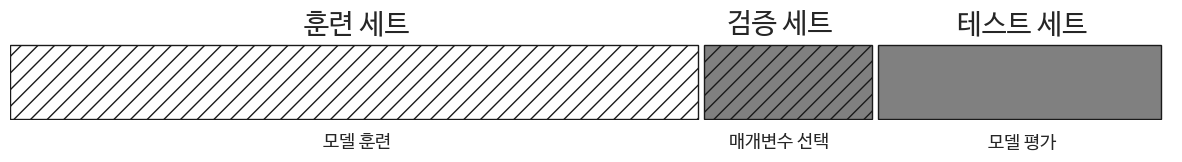

In [6]:
mglearn.plots.plot_threefold_split()

In [7]:
from sklearn.svm import SVC
iris = load_iris()

# 데이터를 훈련+검증 셋 그리고 테스트 셋으로 분할
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
# 훈련+검증 셋을 훈련 셋와 검증 셋으로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)
print("훈련 세트의 크기: {} 검증 세트의 크기: {} 테스트 세트의 크기: {}".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
  for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    # 매개변수의 각 조합에 대해 svc 훈련
    svm = SVC(gamma=gamma, C=C)
    svm.fit(X_train, y_train)
    # testset svc 평가
    score = svm.score(X_valid, y_valid)
    # 점수가 더 높으면 매개변수와 함께 기록
    if score > best_score:
      best_score = score
      best_parameters = {"C":C, "gamma":gamma}

# 훈련셋 검증 셋 합쳐 하나의 모델을 다시 만듬
# 테스트 셋을 사용해 평가합니다.
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)

print("best score in valid set : {:.2f}".format(best_score))
print("best parameters :", best_parameters)
print("best score in test set: {:.2f}".format(test_score))

훈련 세트의 크기: 84 검증 세트의 크기: 28 테스트 세트의 크기: 38
best score in valid set : 0.96
best parameters : {'C': 10, 'gamma': 0.001}
best score in test set: 0.92


### 5.2.3 교차 검증을 사용한 그리드 서치


In [8]:
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
  for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    # 매개변수의 각 조합에 대해 svc 훈련
    svm = SVC(gamma=gamma, C=C)
    # 교차 검증을 적용
    scores = cross_val_score(svm, X_trainval, y_trainval, cv= 5)
    # 교차 검증 정확도ㅢ 평균을 구한다.
    score = np.mean(scores)
    # 점수가 더 높으면 매개변수와 함께 기록
    if score > best_score:
      best_score = score
      best_parameters = {'C': C, 'gamma': gamma}

# 훈련 세트와 검증 세트를 합쳐 모델을 다시 만든다.
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)


SVC(C=10, gamma=0.1)

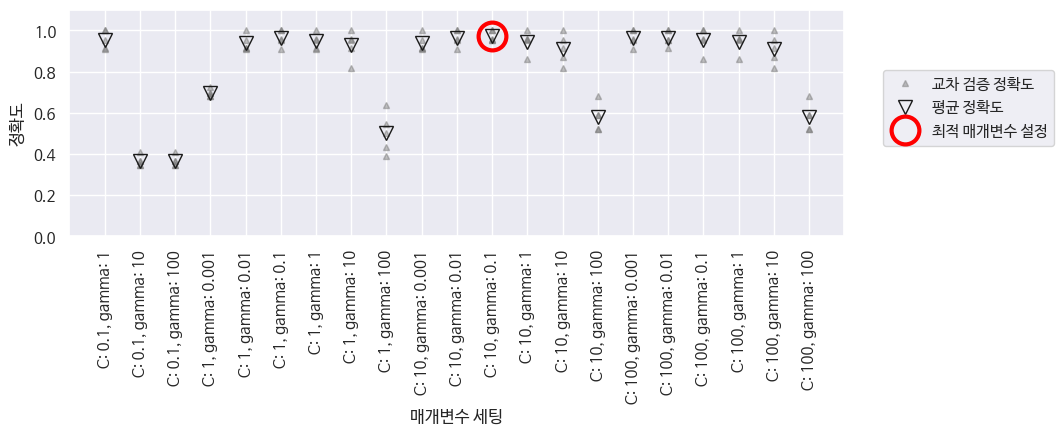

In [9]:
mglearn.plots.plot_cross_val_selection()

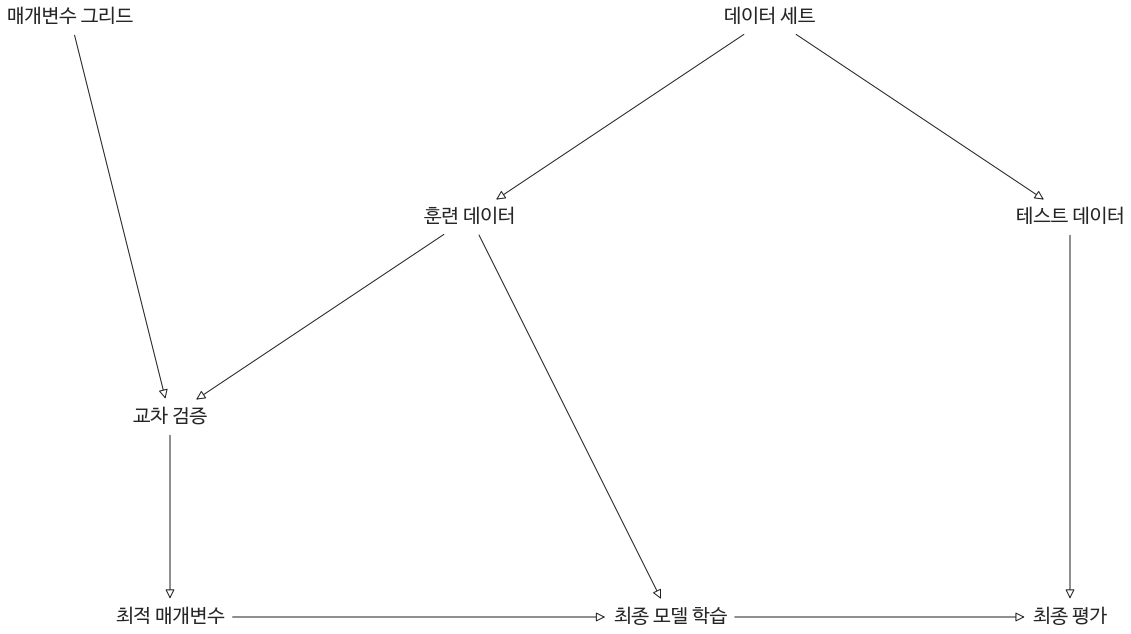

In [10]:
mglearn.plots.plot_grid_search_overview()

교차 검증을 사용한 그리드 서치를 매개변수 조정 방법으로 널리 사용하기 때문에 scikit learn은 추정기 형태로 구현된 GridSearchCV 를 제공하고 있따. 이를 사용하려면 먼저 딕셔너리 형태로 검색 대상 매개변수를 지정해야 한다.GridSearchCV는 필요한 모든 모델을 학습시킨다. 

In [11]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print('매개변수 그리드: \n', param_grid)

매개변수 그리드: 
 {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [12]:
from seaborn.axisgrid import Grid
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

In [14]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             return_train_score=True)

In [15]:
print("테스트 셋 점수 : {:.2f}".format(grid_search.score(X_test, y_test)))

테스트 셋 점수 : 0.97


In [16]:
print('최적의 매개변수:', grid_search.best_params_)
print('최고 교차 검증 점수: {:.2f}'.format(grid_search.best_score_))

최적의 매개변수: {'C': 10, 'gamma': 0.1}
최고 교차 검증 점수: 0.97


In [17]:
print('최고 성능 모델:\n', grid_search.best_estimator_)

최고 성능 모델:
 SVC(C=10, gamma=0.1)


### 교차 검증 결과 분석


In [25]:
import pandas as pd
pd.set_option('display.max_columns', None)
# DataFrame 변환
results = pd.DataFrame(grid_search.cv_results_)
# 처음 다석 개 행을 출력한다.
np.transpose(results.head())

,0,1,2,3,4
mean_fit_time,0.0,0.0,0.0,0.0,0.0
std_fit_time,0.0,0.0,0.0,0.0,0.0
mean_score_time,0.0,0.0,0.0,0.0,0.0
std_score_time,0.0,0.0,0.0,0.0,0.0
param_C,0.0,0.0,0.0,0.0,0.0
param_gamma,0.0,0.01,0.1,1,10
param_kernel,rbf,rbf,rbf,rbf,rbf
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}"
split0_test_score,0.35,0.35,0.35,0.35,0.35
split1_test_score,0.35,0.35,0.35,0.35,0.35


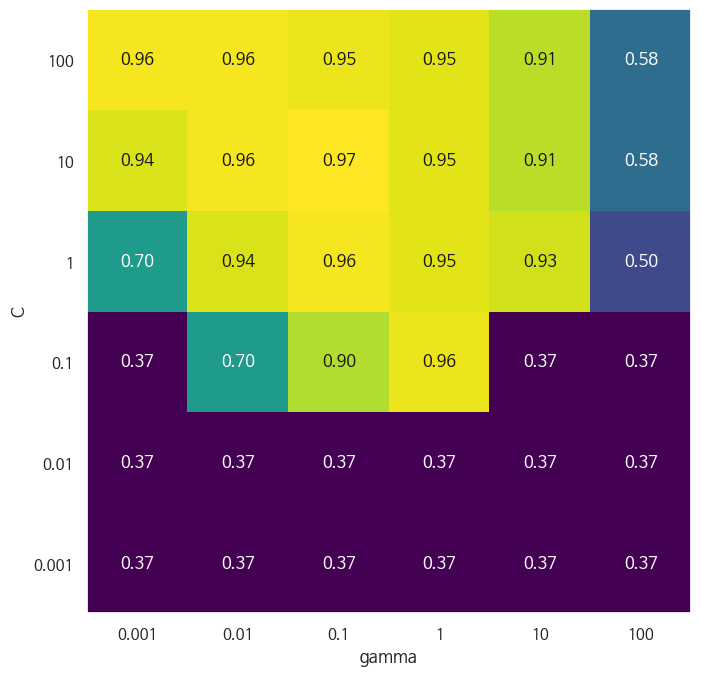

In [19]:
scores = np.array(results.mean_test_score).reshape(6, 6)

# 교차 검증 평균 점수 히트맵 그래프
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'], cmap="viridis")
plt.show() # 책에는 없음

히트맵의 각 포인트는 특정 매개변수 설정에 대하 고차 검증 실행을 나타낸다. 교차 검증의 정확도가 높으면 밝은 색으로, 낮으면 어두운색으로 나타낸다. 그래프를 보면 svc가 매개변수 설정에 매우 민감함을 알 수 있다. 많은 매개변수 설정에서 40%부근의 낮은 정확도를 내고, 일부는 96%이상의 정확도를 만들었다.
그래프를 통해 몇가지 정보를 얻을 수 있다. 
- 매개변수 조정은 중요하다
- 어떻게 조정하나에 따라서 40%~96% 까지 차이가 난다.
- 그리드를 보면 밝은 부분이 반대편 끝에 닿지 않을 만큼 충분히 범위가 넓어야 한다


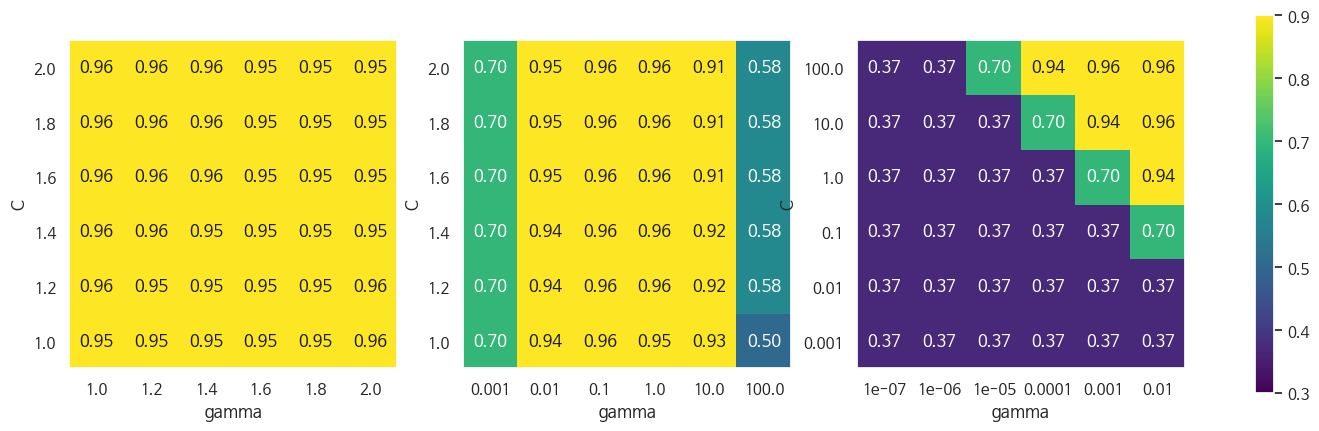

In [20]:
# 잘못된 그리디 범위 그래프 그리기
from sklearn.model_selection import GridSearchCV

fig, axes = plt.subplots(1,3,figsize=(18,5))
param_grid_linear = {'C': np.linspace(1,2,6), 'gamma': np.linspace(1,2,6)}

param_grid_one_log = {'C': np.linspace(1,2,6), 'gamma': np.logspace(-3,2,6)}

param_grid_range = {'C': np.logspace(-3,2,6), 'gamma': np.logspace(-7,-2,6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], axes):
  grid_search =GridSearchCV(SVC(), param_grid, cv=5)
  grid_search.fit(X_train, y_train)
  scores = grid_search.cv_results_['mean_test_score'].reshape(6,6)
  
  # 교차 검증 평균 점수의 히트맵 그래프
  scores_image = mglearn.tools.heatmap(
        scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'],
        yticklabels=param_grid['C'], cmap="viridis", ax=ax, vmin=0.3, vmax=0.9)
    
plt.colorbar(scores_image, ax=axes.tolist())
plt.show() # 책에는 없음

1. 그래프 그리드 변화가 전혀 없는 그래프.

매개변수 c와 gamma의 스케일 번위가 부저절한 경우 발생한다. 그러나 매개 변수 설정이 바뀌어도 변화가 없다면 그 매개 변수가 전혀중요하지 않은 것일 수도 있다.
따라서 처음은 극단적인 값을 적용해보고 매개변수를 바꿔가며 정확도가 변하는지 살펴보는 것이 중요하다.

\
2. 세로 띠 형태 그래프

gamma 매개 변수는 적절한 범위를 의미하고 c 는 적절한 범위가 아니거나 중요하지 않다는 의미이다.

\
3. c와 gamma 둘 모두 변했으나 왼쪽아래 영역은 변화가 없는 경우

경계 범위를 변경해서 더 낳은 값을 찾을 수 있다.

\
교차 검증을 토대로 매개변수 그리드를 튜닝하는 것은 아주 안전한 방법이며, 매개변수들읠 중요도를 확인하는 데에도 좋다. 그러나 최종 테스트 셋을 대상으로 여러 매개변수 범위를 테스트해서는 않된다.테스트 셋 평가는 사용할 모델이 결정되고 한번만 해야한다.(사후 판단 평향 방지)


### 비대칭 매개변수 그리드 탐색
어떤 경우 매개변수 조합에 대해 GridSearchCV 를 수행하는 것이 좋은 생각이 아닐 수 있다. 예를 를면 svc 는 kernel 매개변수를 가지고 있는데 어떤 커널을 사용하는지에 따라 관련 있는 매개변수들이 결정된다. kernel='linear'이면 선형모델이고 C만 사용한다. kernel='rbf'는 C와 gamma를 모두 사용한다. 하지만 다른 매개변수는 사용하지 않는다. 이런 경우에 c, gamma, kernel 매개변수의 모든 조합을 조사하는 것은 맞지 않다. 이런 조건부 매개변수 조합을 적용하려면 ,GridSearchCV 에 전달한 param_grid를 딕셔너리의 리스트로 만들어 주면 된다. 리스트에있는 각 딕셔너리는 독립적인 그리드로 적용된다. kernel을 포함한 매개변수 그리드의 예는 다음과 같다.

In [21]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
print("그리드 목록:\n", param_grid)

그리드 목록:
 [{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


첫 그리드에서 kernel 매개변수는 rbf로 고정되고, c와 gamma 두 매개변수는 바뀐다. 두번째 그리드에서 kernel 매개변수는 항상 linear로 고정되고 c만 바뀐다. 이제 이 매개 변수 그리드를 적용해 보자.

In [22]:
grid_search =GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)
print('최적 파라미터:', grid_search.best_params_)
print('최고 교차 검증 점수: {:.2f}'.format(grid_search.best_score_))

최적 파라미터: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
최고 교차 검증 점수: 0.97


In [23]:
results = pd.DataFrame(grid_search.cv_results_)
# 좀더 나은 출력을 위해 결과를 전치시킨다.
results.T

# linear 일때는 C만 변경되었다.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std_fit_time,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean_score_time,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std_score_time,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
param_C,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.01,0.01,0.01,0.01,0.01,0.1,0.1,0.1,0.1,0.1,0.1,1,1,1,1,1,1,10,10,10,10,10,10,100,100,100,100,100,100,0.0,0.01,0.1,1,10,100
param_gamma,0.0,0.01,0.1,1,10,100,0.0,0.01,0.1,1,10,100,0.0,0.01,0.1,1,10,100,0.0,0.01,0.1,1,10,100,0.0,0.01,0.1,1,10,100,0.0,0.01,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 100, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 1, 'gamma': 1, 'kernel': 'rbf'}","{'C': 1, 'gamma': 10, 'kernel': 'rbf'}","{'C': 1, 'gamma': 100, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 10, 'gamma': 1, 'kernel': 'rbf'}","{'C': 10, 'gamma': 10, 'kernel': 'rbf'}","{'C': 10, 'gamma': 100, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.7,0.91,1.0,0.35,0.35,0.7,0.91,1.0,0.96,0.91,0.39,0.91,1.0,1.0,0.96,0.87,0.52,1.0,1.0,1.0,0.96,0.87,0.52,0.35,0.87,1.0,1.0,1.0,0.96
split1_test_score,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.7,0.91,0.91,0.35,0.35,0.7,0.91,0.96,0.91,0.96,0.43,0.91,0.96,0.96,0.96,0.91,0.52,0.96,0.91,0.96,0.96,0.91,0.52,0.35,0.87,0.91,0.96,1.0,0.96


### 그리드 서치의 다양한 교차 검증 적용

cross_val_score 와 비슷하게 GridSearchCV 는 분류에는 기본적으로 계층형 k-겹 교차 검증을 사용한다. 그러나 매개변수 cv를 통해 330 페이지의 교차검증 상세 옵션절에 나온 다른 교차 검증 분할기를 사용할 수도 있다. 훈련셋과 검증섯으로 한번만 분할 하려면 n_splits=1로 하고, ShuffleSplit 나 StratifiedSuffleSplit을 사용한다. 이 방법은 매우 크거나 모델 구축시간이 오래걸릴때 유용하다

## 중첩교차 검증
그리드서치를 통해 찾은 매개변수가 모델을 얼마나 잘 일반화시키는지 알려준다.

In [30]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5), iris.data, iris.target, cv=5)
print('교차 검증 점수: ', scores)
print('교차 검증 평균 점수: ', scores.mean())

교차 검증 점수:  [0.967 1.    0.967 0.967 1.   ]
교차 검증 평균 점수:  0.9800000000000001


In [38]:
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    # outer_cv의 분할을 순회하는 for 루프
    # (split 메소드는 훈련과 테스트 세트에 해당하는 인덱스를 리턴합니다)
    for training_samples, test_samples in outer_cv.split(X, y):
        # 최적의 매개변수를 찾습니다
        best_parms = {}
        best_score = -np.inf
        # 매개변수 그리드를 순회합니다
        for parameters in parameter_grid:
            # 안쪽 교차 검증의 점수를 기록합니다
            cv_scores = []
            # inner_cv의 분할을 순회하는 for 루프
            for inner_train, inner_test in inner_cv.split(
                    X[training_samples], y[training_samples]):
                # 훈련 데이터와 주어진 매개변수로 분류기를 만듭니다
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                # 검증 세트로 평가합니다
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
            # 안쪽 교차 검증의 평균 점수를 계산합니다
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                # 점수가 더 높은면 매개변수와 함께 기록합니다
                best_score = mean_score
                best_params = parameters
        # 바깥쪽 훈련 데이터 전체를 사용해 분류기를 만듭니다
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        # 테스트 세트를 사용해 평가합니다
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
    return np.array(outer_scores)


In [39]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold
scores = nested_cv(iris.data, iris.target, StratifiedKFold(5),
                   StratifiedKFold(5), SVC, ParameterGrid(param_grid))
print("교차 검증 점수:", scores)

교차 검증 점수: [0.967 1.    0.967 0.967 1.   ]


### 교차 검증과 그리드 서치 병렬화
코어수 지정할 수 있다. 데이터섹과 모델이 매우 클때 여러코어를 사용하면 너무 많은 메모리를 차지한다. 대규모 모델을 병렬로 만들 땐 메모리 사용 현황을 모니터리하는 것이 좋다.

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

param_dist = [{'kernel': ['rbf'],
               'C': loguniform(0.001, 100),
               'gamma': loguniform(0.001, 100)},
              {'kernel': ['linear'],
               'C': loguniform(0.001, 100)}]

In [41]:
rand_search = RandomizedSearchCV(SVC(), param_dist, n_iter=20, 
                                 random_state=42, n_jobs=-1)
rand_search.fit(X_train, y_train)
print("최적 파라미터:", rand_search.best_params_)
print("최고 교차 검증 점수: {:.2f}".format(rand_search.best_score_))

최적 파라미터: {'C': 1.7965626423790642, 'kernel': 'linear'}
최고 교차 검증 점수: 0.97


In [42]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
halv_search = HalvingGridSearchCV(SVC(), param_grid, verbose=1,
                                  random_state=42, n_jobs=-1)
halv_search.fit(X_train, y_train)
print()
print("최적 파라미터:", halv_search.best_params_)
print("최고 교차 검증 점수: {:.2f}".format(halv_search.best_score_))

n_iterations: 2
n_required_iterations: 4
n_possible_iterations: 2
min_resources_: 30
max_resources_: 112
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 42
n_resources: 30
Fitting 5 folds for each of 42 candidates, totalling 210 fits
----------
iter: 1
n_candidates: 14
n_resources: 90
Fitting 5 folds for each of 14 candidates, totalling 70 fits

최적 파라미터: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
최고 교차 검증 점수: 0.97


In [43]:
print('자원 리스트:', halv_search.n_resources_)
print('후보 리스트:', halv_search.n_candidates_)

자원 리스트: [30, 90]
후보 리스트: [42, 14]
